In [1]:
import scanpy as sc
import episcanpy as epi
import numpy as np
import sklearn
import torch
from Fountain.data import create_dataloader,create_batchind_dict
from Fountain.fountain import Fountain
import scib
import matplotlib.pyplot as plt
import scipy
import os
import warnings
warnings.filterwarnings("ignore")

# Data preprocessing

The example data for batch correction can be download at [here](https://drive.google.com/file/d/1qwKP1xzYVs5rEGRJPU_NJga2Gl0qSTv5/view?usp=sharing
).

In [2]:
adata=sc.read_h5ad('mouse_brain.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 13671 × 479127
    obs: 'batch', 'cell_type', 'cell_type_raw', 'test_type'
    var: 'peak'

In [4]:
fpeak=0.04
epi.pp.binarize(adata)
epi.pp.filter_features(adata, min_cells=np.ceil(fpeak*adata.shape[0]))

In [5]:
adata

AnnData object with n_obs × n_vars = 13671 × 22320
    obs: 'batch', 'cell_type', 'cell_type_raw', 'test_type'
    var: 'peak', 'n_cells'

#  Model initialization

In [6]:
batchind_dict=create_batchind_dict(adata,batch_name='batch')
batchsize=min(128*len(batchind_dict),1024)
dataloader=create_dataloader(adata,batch_size=batchsize,batchind_dict=batchind_dict,batch_name='batch',num_worker=4,droplast=False)
enc=[['fc', 1024, '', 'gelu'],['fc', 256, '', 'gelu'],['fc', 16, '', '']]
dec=[['fc', adata.X.shape[1], '', '']]
early_stopping= None
device='cuda:0'

In [7]:
model=Fountain(adata,enc,dec, n_domain=len(create_batchind_dict(adata,batch_name='batch')),batch_name='batch')

# Model training

In [8]:
model.train(            
            dataloader,             
            lambda_mse=0.005, 
            lambda_Eigenvalue=0.5,
            max_iteration=30000,
            mid_iteration=3000,
            early_stopping=early_stopping,
            device=device, 
        )

Epochs: 100%|█| 556/556 [22:59<00:00,  2.48s/it, recon_loss=8785.936,kl_loss=33.


The trainig process is expected to take under 30 minutes.

# Get batch corrected low-dimensional embedding

In [9]:
emb='fountain'
adata.obsm[emb]=model.get_latent(dataloader,device=device)

UMAP visualization

2024-12-20 01:43:55.405440: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-20 01:43:55.667630: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-20 01:43:56.847061: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


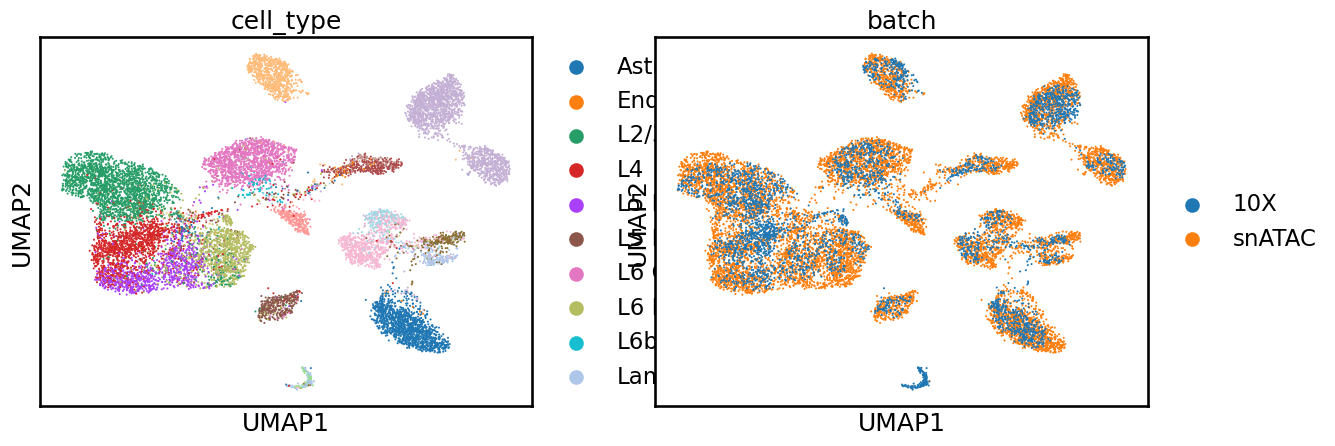

In [10]:
sc.pp.neighbors(adata, use_rep='fountain')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['cell_type','batch'])

# Generate batch-corrected and enhanced ATAC profiles in the original dimension

In [11]:
adata.layers['enhance']=model.enhance(adata,device='cuda:0',batch_name='batch')

UMAP plots colored by the sequencing depth of raw ATAC profiles. In order to provide a clear visualization of sequencing depth, we used the UMAP embeddings of the low dimensional cell representations corrected by Fountain, and colored it using the sequencing depth of the raw data.

[<Axes: title={'center': 'sequencing depth(log10)'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'cell_type'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'batch'}, xlabel='UMAP1', ylabel='UMAP2'>]

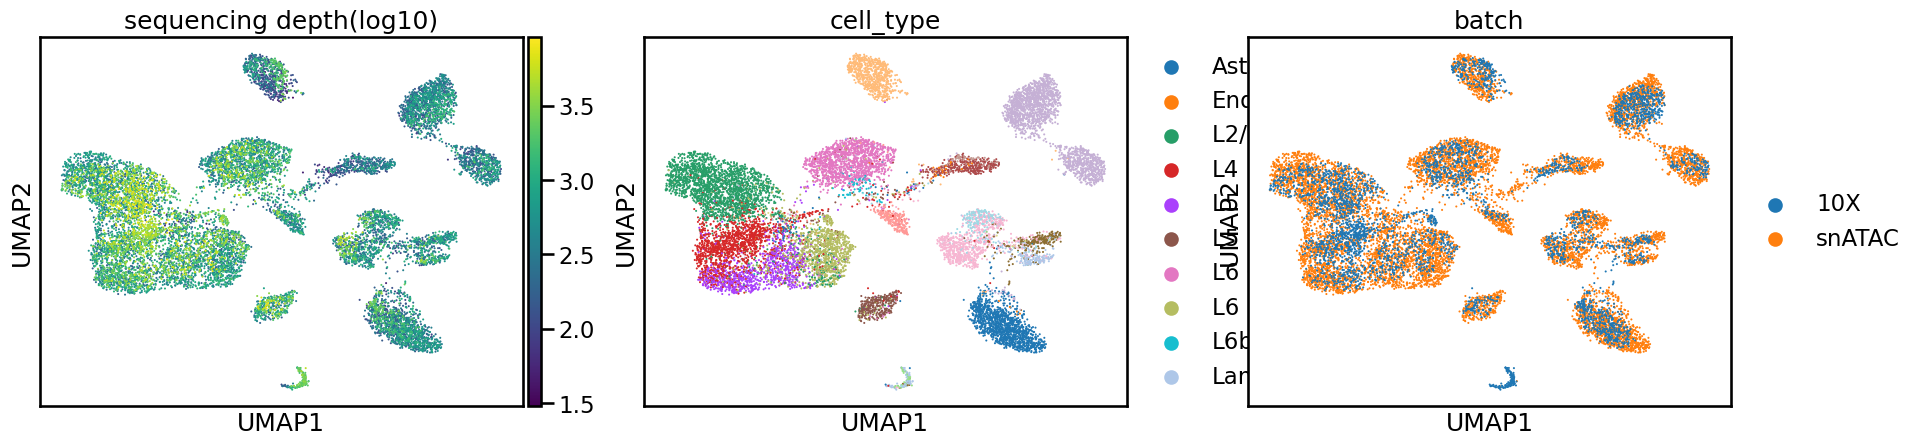

In [12]:
adata_en = adata.copy()
sc.pp.neighbors(adata_en, use_rep='fountain')
sc.tl.umap(adata_en)
count_sum_per_cell = adata_en.X.sum(axis=1)
adata_en.obs['sequencing depth'] = count_sum_per_cell
adata_en.obs['sequencing depth(log10)'] = np.log10(count_sum_per_cell)
sc.pl.umap(adata_en, color=["sequencing depth(log10)",'cell_type','batch'],show=False,color_map='viridis')

UMAP plots colored by the sequencing depth of batch-corrected and enhanced ATAC profiles with Fountain corrected cell embeddings.

[<Axes: title={'center': 'sequencing depth(log10)'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'cell_type'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'batch'}, xlabel='UMAP1', ylabel='UMAP2'>]

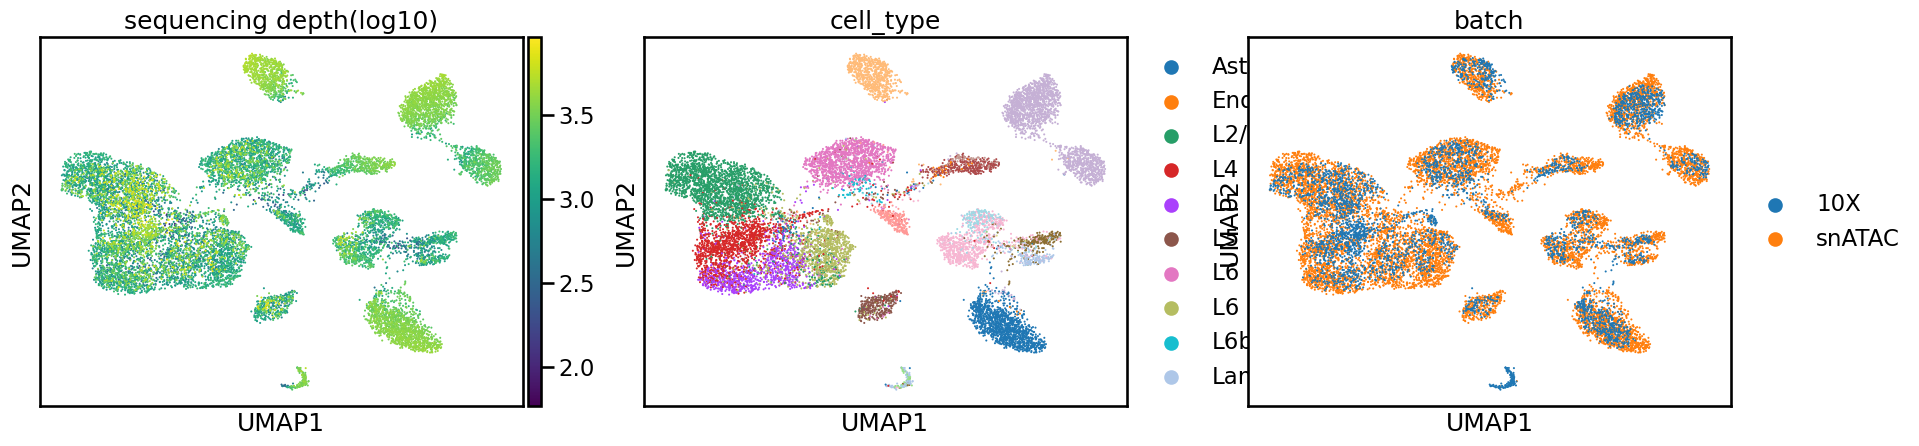

In [13]:
adata_en = adata.copy()
adata_en.X = adata_en.layers['enhance']
sc.pp.neighbors(adata_en, use_rep='fountain')
sc.tl.umap(adata_en)
count_sum_per_cell = adata_en.X.sum(axis=1)
adata_en.obs['sequencing depth'] = count_sum_per_cell
adata_en.obs['sequencing depth(log10)'] = np.log10(count_sum_per_cell)
sc.pl.umap(adata_en, color=["sequencing depth(log10)",'cell_type','batch'],show=False,color_map='viridis')